In [0]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

# Generate Track

In [0]:
b_cones = np.load("blue_cones.npy")
y_cones = np.load("yellow_cones.npy")

In [0]:
b_cones

array([[8.70967742, 0.98951258],
       [8.64919355, 2.26647829],
       [8.42741935, 3.7064609 ],
       [8.125     , 4.92908765],
       [7.64112903, 5.8256806 ],
       [7.05645161, 6.50491768],
       [6.14919355, 7.02113786],
       [5.26209677, 7.21132424],
       [4.39516129, 7.23849372],
       [3.56854839, 7.12981579],
       [2.5       , 6.66793458]])

In [0]:
np.random.shuffle(b_cones)
np.random.shuffle(y_cones)

In [0]:
start = np.array([8,0])

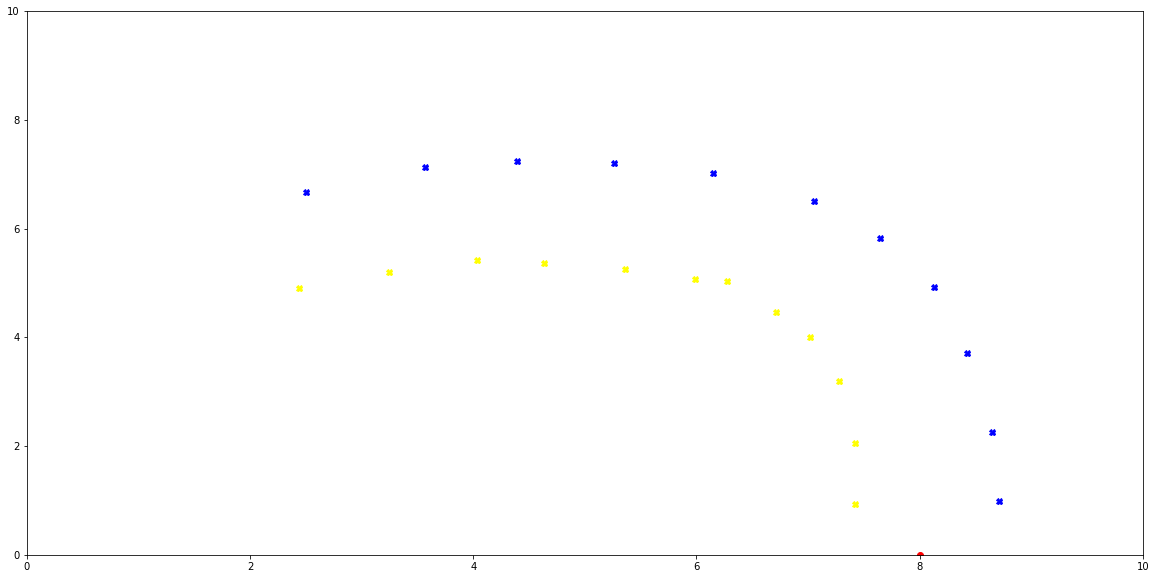

In [0]:
plt.figure(1, figsize=(20,10))
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.plot(b_cones[:,0], b_cones[:,1], "X", color="blue")
plt.plot(y_cones[:,0], y_cones[:,1], "X", color="yellow")
plt.plot(start[0], start[1], "o", color="red")


# Algorithm
## Initialize loop
1) find first blue (resp. yellow) cone
\begin{equation*}
    b_1 = argmin_{b \in B} ||s - b|| \\
    y_1 = argmin_{y \in Y} ||s - y|| 
\end{equation*}
where $B \ (\text{resp.} \ Y)$ is set of all detected blue cones (resp. yellow cones).

2) connect firsts cones by line and parametrize this line (line in 2D is $     f(x) = k\cdot x + c$) so

\begin{equation*}
    b_1[1] = k\cdot b_1[0] + c\\
    y_1[1] = k\cdot y_1[0] + c\\
    \text{that means}\\
    k = \frac{b_1[1]-y_1[1]}{b_1[0]-y_1[0]} \ \text{and} \ c = b_1[1] - k\cdot b_1[0]
\end{equation*}

We assume that in first loop it is also normal line to car's direction.

3) new start point is center between cones $\vec{s_0} = (s_{0}[0] ,s_{0}[1]) $
\begin{equation*}
    s_{0}[0] = \frac{b_{1}[0]-y_{1}[0]}{2},\\
    s_{0}[1] = \frac{b_{1}[1]-y_{1}[1]}{2}
\end{equation*}


## common loop
1) find first blue (resp. yellow) cone
\begin{equation*}
    b_2 = argmin_{b \in \hat{B}} ||s - b|| \\
    y_2 = argmin_{y \in \hat{Y}} ||s - y|| 
\end{equation*}
where $\hat{B} = \{b \in B \text{ and }  \& \ sign(b[1]-k\cdot b[0] - c)=1\} \ (\text{resp.} \ \hat{Y})$ is set of all detected blue cones (resp. yellow cones) in front of car.

2) find center (new start point) $\vec{s_1} = (s_{1}[0] ,s_{1}[1]) $
\begin{equation*}
    s_{1}[0] = \frac{b_{2}[0]-y_{2}[0]}{2}+ y_2[0], \\
    s_{1}[1] = \frac{b_{2}[1]-y_{2}[1]}{2}+ y_2[1]
\end{equation*}

3) find direction $\vec{s_1}-\vec{s_0}$
\begin{equation*}
    s_1[1] = k\cdot s_1[0] + c\\
    s_0[1] = k\cdot s_0[0] + c\\
    \text{that means}\\
    k = \frac{s_1[1]-s_0[1]}{s_1[0]-s_0[0]} \ \text{  and  } \ c = s_1[1] - k\cdot s_1[0]
\end{equation*}

4) find normal line to direction in point $\vec{s_1}$
\begin{equation*}
    k_{new} = -\frac{1}{k} \text{  and  } c_{new} = s_1[1] - k_{new}\cdot s_1[0],\\
    \text{normal line is than }\\
    f(x) = k_{new}\cdot x + c_{new}
\end{equation*}

## back to step one


# Algorithm

In [0]:
class pathplanning(object):
    def __init__(self, start_point):
        self.sorted_blue_cones = []
        self.sorted_yellow_cones = []
        self.start_points = [start_point]
        # parameters of normal line
        self.k = None
        self.c = None

    def reset(self, start_point):
        self.sorted_blue_cones = []
        self.sorted_yellow_cones = []
        self.start_points = [start_point]
        # parameters of normal line
        self.k = None
        self.c = None

    def is_already_added(self, point):
        np.all(np.isin(point, self.sorted_yellow_cones))
        return (np.all(np.isin(point, self.sorted_yellow_cones)) or np.all(np.isin(point, self.sorted_blue_cones)))

    def points_above_normal(self, points):
        return points[np.sign(points[:,1] - self.k * points[:,0] - self.c)==1]

    def find_closest_one(self, points):
        closest_index = np.argmin(np.linalg.norm(points-self.start_points[-1], axis=1))
        closest_cone = points[closest_index]
        return closest_cone

    def calculate_center(self, pointB, pointY):
        return np.array([(pointB[0]-pointY[0])/2 + pointY[0], (pointB[1]-pointY[1])/2 + pointY[1]])
    
    def return_stack(self, object_name):
        if object_name == "yellow cones":
            return np.vstack(self.sorted_yellow_cones)
        elif object_name == "blue cones":
            return np.vstack(self.sorted_blue_cones)
        elif object_name == "centers":
            return np.vstack(self.start_points)           

    def find_line_parameters(self, pointB, pointY, normal=True):
        k = (pointB[1]-pointY[1])/(pointB[0]-pointY[0])
        self.k = -1/k if normal else k 
        c = pointB[1] - self.k*pointB[0]
        self.c = c

    def find_next_center(self, pointsB, pointsY, step=None, verbose=True):
        self.find_line_parameters(self.start_points[-1], self.start_points[-2])
        B_hat = self.points_above_normal(pointsB)
        Y_hat = self.points_above_normal(pointsY)
        #set_trace()
        b = self.find_closest_one(B_hat)
        y = self.find_closest_one(Y_hat)

        if not self.is_already_added(b):
            self.sorted_blue_cones.append(b)
        if not self.is_already_added(y):
            self.sorted_yellow_cones.append(y)

        s = self.calculate_center(b, y)
        self.start_points.append(s)
        if verbose:
            if step != None:
                print("Step {} done!".format(step))
            else:
                print("Step done!")

    def find_path(self, B, Y, n_steps, verbose=True):
        if n_steps < 1:
            raise ValueError("Number of steps must be positive!!")
        """
            B is set of all blue cones
            Y is set of all yellow cones
        """
        # initializing loop
        # step 1)
        b_0 = self.find_closest_one(B)
        y_0 = self.find_closest_one(Y)
        self.sorted_blue_cones.append(b_0)
        self.sorted_yellow_cones.append(y_0)

        s_1 = self.calculate_center(b_0, y_0)
        self.start_points.append(s_1)
        if verbose:
            print("Step 1 done!")

        # step 2)
        if n_steps > 1:
            self.find_line_parameters(b_0, y_0, normal=False) # special case of separate line for 2nd step
            B_hat = self.points_above_normal(B)
            Y_hat = self.points_above_normal(Y)
            #set_trace()
            b_1 = self.find_closest_one(B_hat)
            y_1 = self.find_closest_one(Y_hat)
            self.sorted_blue_cones.append(b_1)
            self.sorted_yellow_cones.append(y_1)

            s_2 = self.calculate_center(b_1, y_1)
            self.start_points.append(s_2)
            if verbose:
                print("Step 2 done!")

        #every other step
        if n_steps >2:
            for step in range(n_steps-2):
                self.find_next_center(B, Y, step+2, verbose=verbose)


# testy

In [0]:
path = pathplanning(np.array([8,0]))

In [0]:
vars(path)

{'c': None,
 'k': None,
 'sorted_blue_cones': [],
 'sorted_yellow_cones': [],
 'start_points': [array([8, 0])]}

In [0]:
path.find_path(B=b_cones, Y=y_cones, n_steps=1, verbose=True)

Step 1 done!


In [0]:
vars(path)

{'c': None,
 'k': None,
 'sorted_blue_cones': [array([8.70967742, 0.98951258])],
 'sorted_yellow_cones': [array([7.41935484, 0.93517361])],
 'start_points': [array([8, 0]), array([8.06451613, 0.9623431 ])]}

In [0]:
path.reset(np.array([8,0]))

In [0]:
vars(path)

{'c': None,
 'k': None,
 'sorted_blue_cones': [],
 'sorted_yellow_cones': [],
 'start_points': [array([8, 0])]}

In [0]:
path.find_path(B=b_cones, Y=y_cones, n_steps=2, verbose=True)

Step 1 done!
Step 2 done!


In [0]:
vars(path)

{'c': 0.6227245557789521,
 'k': 0.04211269901646438,
 'sorted_blue_cones': [array([8.70967742, 0.98951258]),
  array([8.64919355, 2.26647829])],
 'sorted_yellow_cones': [array([7.41935484, 0.93517361]),
  array([7.41935484, 2.04912243])],
 'start_points': [array([8, 0]),
  array([8.06451613, 0.9623431 ]),
  array([8.03427419, 2.15780036])]}

In [0]:
starts = np.vstack(path.start_points)
starts

array([[8.        , 0.        ],
       [8.06451613, 0.9623431 ],
       [8.03427419, 2.15780036]])

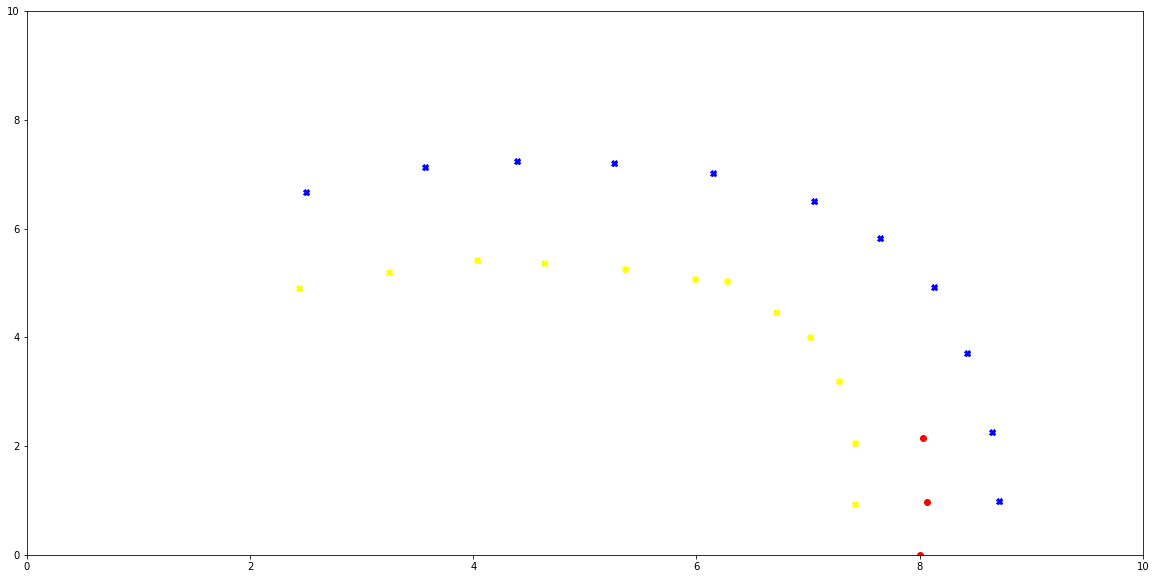

In [0]:
plt.figure(1, figsize=(20,10))
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.plot(b_cones[:,0], b_cones[:,1], "X", color="blue")
plt.plot(y_cones[:,0], y_cones[:,1], "X", color="yellow")
plt.plot(starts[:,0],starts[:,1], "o", color="red")
#axis = np.linspace(0, 10)
#plt.plot(axis, k*axis+c, color="green")
#plt.plot(new_start[0], new_start[1], "o", color="red")

In [0]:
path.reset(np.array([8,0]))

In [0]:
path.find_path(B=b_cones, Y=y_cones, n_steps=17, verbose=True)

Step 1 done!
Step 2 done!
Step 2 done!
Step 3 done!
Step 4 done!
Step 5 done!
Step 6 done!
Step 7 done!
Step 8 done!
Step 9 done!
Step 10 done!
Step 11 done!
Step 12 done!
Step 13 done!
Step 14 done!
Step 15 done!
Step 16 done!


In [0]:
path.k

11.130846774193365

In [0]:
path.c

-40.57384073486158

In [0]:
starts = path.return_stack(object_name="centers")
Y_cones = path.return_stack(object_name="yellow cones")
B_cones = path.return_stack(object_name="blue cones")

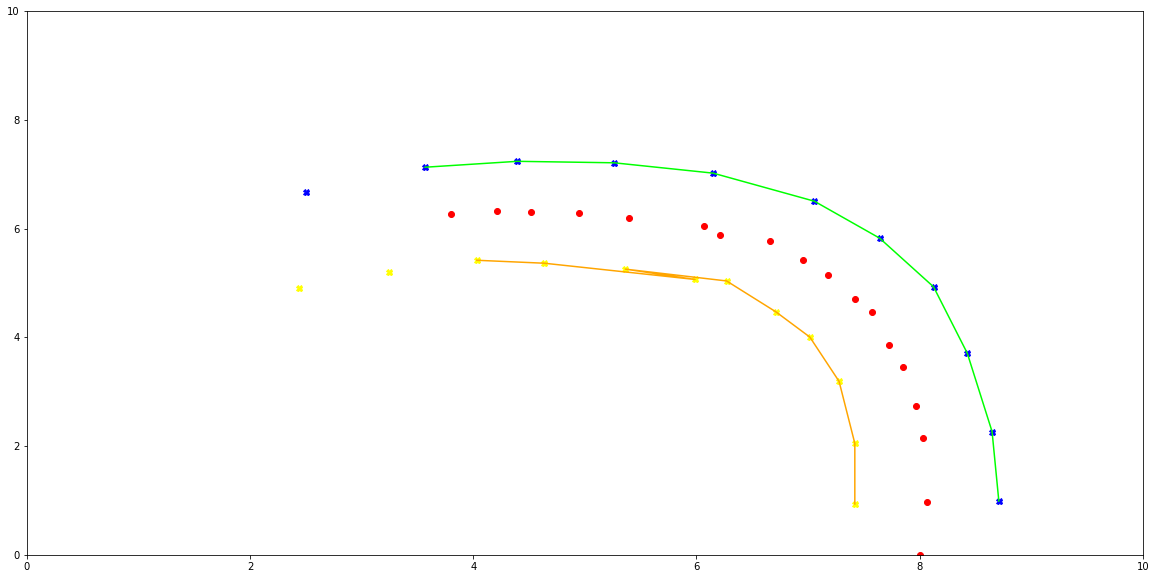

In [0]:
plt.figure(1, figsize=(20,10))
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.plot(b_cones[:,0], b_cones[:,1], "X", color="blue")
plt.plot(y_cones[:,0], y_cones[:,1], "X", color="yellow")
plt.plot(B_cones[:,0], B_cones[:,1], color="lime")
plt.plot(Y_cones[:,0], Y_cones[:,1], color="orange")
plt.plot(starts[:,0],starts[:,1], "o", color="red")